# Introduction to information theory

## Communication over an imperfect channel

One important and interesting challenge is that of communicating information over an imperfect channel. Natural and artificial communication channels are ubiquitous, with some examples

1. The wireless communication system between an antenna on Earth and a satellite, where the medium is the vacuum.
2. A disc drive storing bits, sending it from your present self to your future self, where the medium is a magnetic strip.
3. A cell storing its genetic information, sending it to its future self and to its offspring, where the medium is DNA.

Virtually all real communication channels are noisy to some extent. For instance (1) ambient electromagnetic noise could corrupt the signal that reaches your computer from the router; (2) electromagnetic noise could flip bits in a magnetic disc drive; (3) solar radiation could produce mutations in the DNA of a cell.

The **physical approach** to the communication problem aims to make the channel less noisy. The **system approach** accepts the noise inherent in the channel, and instead builds a system before and after the channel which improves its reliability.

What makes the systems approach very exciting is that it's applicable in situations where the physical approach cannot be realistically applied. For example, we can't hope to make the vacuum between Earth and a satellite less noisy (although we could perhaps try to build better antennae and use stronger signals). Instead, we can accept the noise inherent in the channel and instead **add redundancy** to the communicated messages, which enables the system to recover a more accurate approximation of the original message. 

## The binary symmetric channel

One simple noisy channel that is used throughout the book is the binary symmetric channel. The binary symmetric channel takes a single bit as its input and returns the same bit with probability $1 - p$ or flips the bit with probability $p$:

$$\begin{align}
x_r = \begin{cases}
x_t & \text{ prob. } 1 - p \\
x_t \bigoplus 1 & \text{ prob. } p
\end{cases}
\end{align}$$

where $\bigoplus$ means addition modulo 2. It is called binary symmetric because its input and output are binary and because it has the same flipping probabilities for either a 0 or a 1 input. In general, a channel may not be binary (it could be analogue for example) or symmetric, but this channel is simple and neat to test ideas on. Here's the binay symmetric channel defined as a small helper.

In [107]:
import numpy as np
import matplotlib.pyplot as plt

In [108]:
def binary_symmetric_channel(source, flip_prob):
    
    source_shape = source.shape
    source = source.flatten()
    
    noise = np.random.choice([0, 1], len(source), p=[1 - flip_prob, flip_prob], replace=True)
    
    transmitted = (source + noise) % 2
    transmitted = np.reshape(transmitted, source_shape)
    
    return transmitted

Passing a binary image through this channel we obtain a corrupted version of it.

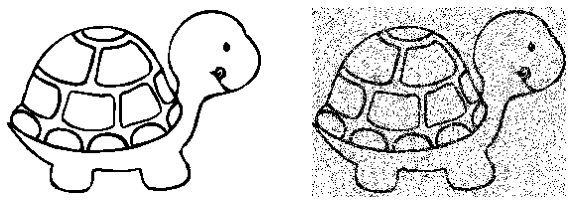

In [114]:
image = np.load('turtle.npy')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='binary')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_symmetric_channel(image, flip_prob=0.1), cmap='binary')
plt.axis('off')

plt.show()

We can now ask: *what can we do to recover a cleaner version of the image on the right?*

## Error correcting codes

### Repetition codes

One way to improve reliability is to repeat the message several times. For example, if we want to transmit the message `01001010` we can send it three times, or equivalently repeat each bit three times. Once the message is sent, each bit is corrupted by noise independently, and received at the other end, where we want to infer what the source message was.

| | | | | | | | | | |
|:-----------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|    source   |  0  |  1  |  0  |  0  |  1  |  0  |  0  |  1  |  0  |
| transmitted | 000 | 111 | 000 | 000 | 111 | 000 | 000 | 111 | 000 |
|    noise    | 000 | 010 | 000 | 110 | 000 | 100 | 000 | 000 | 010 |
|   received  | 000 | 101 | 000 | 110 | 111 | 100 | 000 | 111 | 010 |
|   decoded   |  0  |  1  |  0  |  1  |  1  |  0  |  0  |  1  |  0  |
|   __corrected error__   |    |  *  |    |  *  |    |  *  |    |    |  *  |
|   __error__   |    |    |    |  *  |    |    |    |    |    |

In [9]:
import numpy as np
import itertools
from tqdm import tqdm


def encode(source, G_T):
    return np.dot(G_T, source) % 2


def decode(received, H, decode_dict):
    
    syndrome = np.dot(H, received) % 2
    
    noise = decode_dict[tuple(syndrome)]
    
    decoded = (received + noise) % 2
    
    return decoded, syndrome, noise

In [2]:
def build_decode_dict(H, syndrome_size, code_size):
    
    # All possible syndromes
    syndromes = [(0, 1)] * syndrome_size
    syndromes = list(itertools.product(*syndromes))

    # All possible codes
    codes = [(0, 1)] * code_size
    codes = list(itertools.product(*codes))

    # Decode dictionary to store {syndrome : code} pairs
    decode_dict = {}

    # For each syndrome, code with least 1s which produces the syndrome
    for syndrome in tqdm(syndromes):
        
        syndrome_tup = tuple(syndrome)

        # Loop over all codes, to find the code with least 1s
        for code in codes:
            
            # Num bits in code
            num_bits = np.sum(code)
            
            # Syndrome produced by the code
            code_syndrome = np.dot(H, code) % 2
            code_syndrome_tup = tuple(code_syndrome)

            # If syndrome patterns match, replace code if better than previous
            if syndrome_tup == code_syndrome_tup:

                if syndrome_tup in decode_dict:

                    if (num_bits < decode_dict[syndrome_tup][1]):
                        decode_dict[syndrome_tup] = (code, num_bits)

                else:
                    decode_dict[syndrome_tup] = (code, num_bits)

    # Take out the bit-numbers
    decode_dict = {k : v[0] for k, v in decode_dict.items()}
    
    return decode_dict

## The (7, 4) Hamming code

In [24]:
syndrome_size = 3
code_size = 7

G_T = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 1, 1, 0],
                [0, 1, 1, 1],
                [1, 0, 1, 1]])

H = np.array([[1, 1, 1, 0, 1, 0, 0],
              [0, 1, 1, 1, 0, 1, 0],
              [1, 0, 1, 1, 0, 0, 1]])

In [25]:
hamming_dict = build_decode_dict(H, syndrome_size=syndrome_size, code_size=code_size)

100%|██████████| 8/8 [00:00<00:00, 303.48it/s]


In [26]:
num_source_bits = 4
num_trans = int(1e5)
flip_prob = 1e-1

total_errors = 0
total_bits = num_source_bits * num_trans

for n in range(num_trans):
    
    source_bits = np.random.choice([0, 1], num_source_bits, replace=True)
    
    encoded = encode(source_bits, G_T)
    
    noise = np.random.choice([0, 1], len(encoded), p=[1 - flip_prob, flip_prob], replace=True)
    num_noisy = np.sum(noise)
    
    transmitted = (encoded + noise) % 2
    
    decoded, syndrome, decoded_noise = decode(transmitted, H, hamming_dict)
    
    num_errors = np.sum(encoded[:num_source_bits] != decoded[:num_source_bits])
    
    total_errors = total_errors + num_errors
    
print(f'p(bit error) {total_errors / total_bits:.3f} rate {(code_size - syndrome_size)/code_size:.3f}')

p(bit error) 0.066 rate 0.571


## One (14, 4) code

In [27]:
syndrome_size = 10
code_size = 14

G_T = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 1, 0, 0],
                [1, 1, 0, 0],
                [0, 1, 1, 0],
                [0, 1, 1, 0],
                [0, 0, 1, 1],
                [0, 0, 1, 1],
                [0, 0, 0, 1],
                [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [28]:
custom_dict = build_decode_dict(H, syndrome_size=syndrome_size, code_size=code_size)

100%|██████████| 1024/1024 [05:24<00:00,  3.16it/s]


In [29]:
num_source_bits = 4
num_trans = int(1e5)
flip_prob = 1e-1

total_errors = 0
total_bits = num_source_bits * num_trans

for n in range(num_trans):
    
    source_bits = np.random.choice([0, 1], num_source_bits, replace=True)
    
    encoded = encode(source_bits, G_T)
    
    noise = np.random.choice([0, 1], len(encoded), p=[1 - flip_prob, flip_prob], replace=True)
    num_noisy = np.sum(noise)
    
    transmitted = (encoded + noise) % 2
    
    decoded, syndrome, decoded_noise = decode(transmitted, H, custom_dict)
    
    num_errors = np.sum(encoded[:num_source_bits] != decoded[:num_source_bits])
    
    total_errors = total_errors + num_errors
    
print(f'p(bit error) {total_errors / total_bits:.3f} rate {(code_size - syndrome_size)/code_size:.3f}')

p(bit error) 0.019 rate 0.286
